In [1]:
import json
import os
from pathlib import Path
from collections import Counter
import pandas as pd

# Path to aiscore daily_listings directory
base_path = Path("data/aiscore/daily_listings")

# Dictionary to store league counts
league_counts = Counter()
total_matches = 0
files_processed = 0

# Iterate through all date directories
for date_dir in sorted(base_path.iterdir()):
    if date_dir.is_dir():
        matches_file = date_dir / "matches.json"
        if matches_file.exists():
            try:
                with open(matches_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    
                # Count matches per league
                if 'matches' in data:
                    for match in data['matches']:
                        league = match.get('league', 'Unknown')
                        league_counts[league] += 1
                        total_matches += 1
                    
                    files_processed += 1
                    print(f"Processed {date_dir.name}: {len(data['matches'])} matches")
            except Exception as e:
                print(f"Error processing {matches_file}: {e}")

print(f"\n{'='*60}")
print(f"Summary:")
print(f"{'='*60}")
print(f"Total files processed: {files_processed}")
print(f"Total matches found: {total_matches}")
print(f"Total unique leagues: {len(league_counts)}")
print(f"\n{'='*60}")
print(f"Games per League (sorted by count):")
print(f"{'='*60}")

# Create DataFrame for better display
df = pd.DataFrame([
    {'League': league, 'Game Count': count} 
    for league, count in league_counts.most_common()
])

print(df.to_string(index=False))

Processed 20250901: 48 matches
Processed 20250902: 153 matches
Processed 20250903: 173 matches
Processed 20250904: 95 matches
Processed 20250905: 219 matches
Processed 20250906: 750 matches
Processed 20250907: 597 matches
Processed 20250908: 91 matches
Processed 20250909: 175 matches
Processed 20250910: 112 matches
Processed 20250911: 72 matches
Processed 20250912: 160 matches
Processed 20250913: 795 matches
Processed 20250914: 677 matches
Processed 20250915: 72 matches
Processed 20250916: 167 matches
Processed 20250917: 140 matches
Processed 20250918: 76 matches
Processed 20250919: 177 matches
Processed 20250920: 862 matches
Processed 20250921: 747 matches
Processed 20250922: 67 matches
Processed 20251001: 133 matches
Processed 20251002: 89 matches
Processed 20251003: 185 matches
Processed 20251004: 818 matches
Processed 20251005: 735 matches
Processed 20251006: 53 matches
Processed 20251007: 97 matches
Processed 20251008: 169 matches
Processed 20251009: 101 matches
Processed 20251010

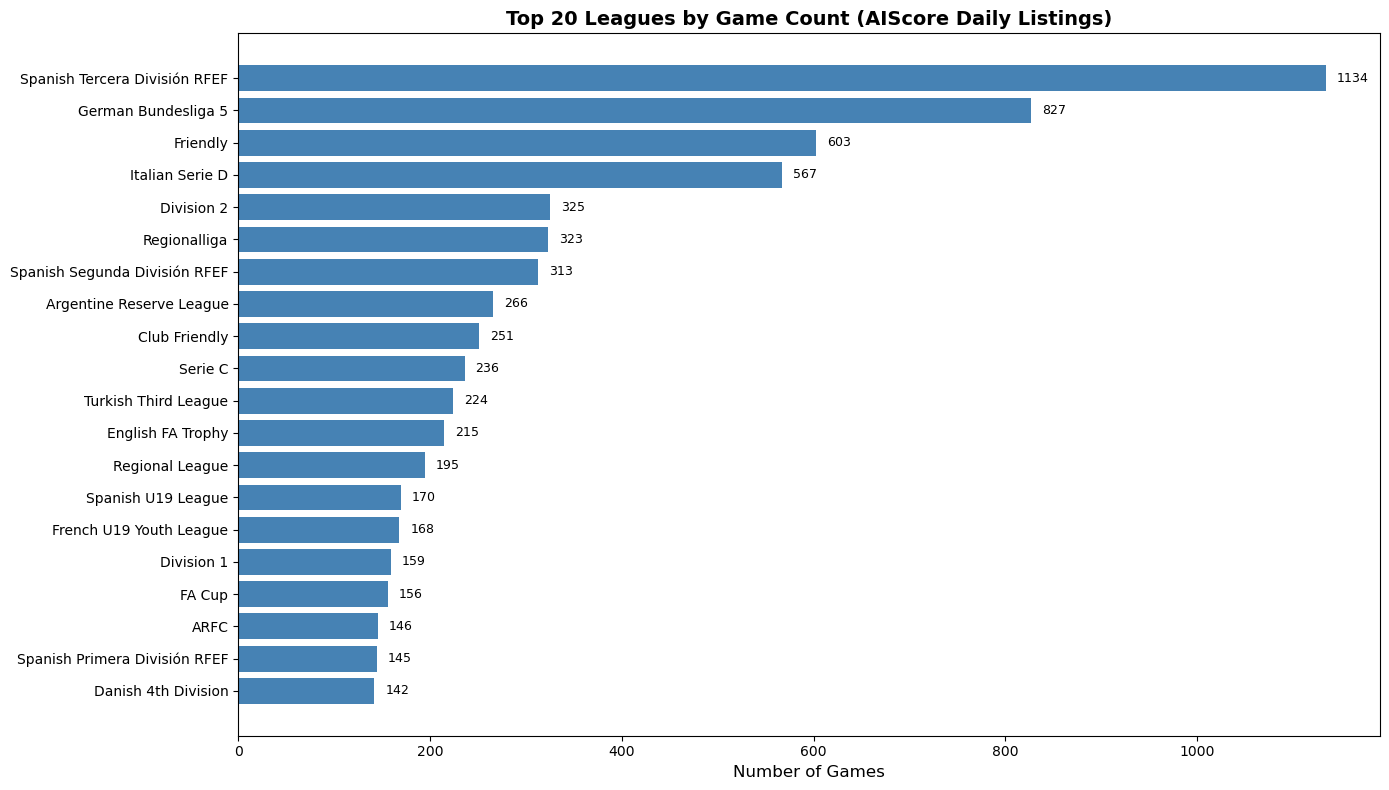

In [2]:
# Visualize top leagues
import matplotlib.pyplot as plt

# Get top 20 leagues by count
top_leagues = league_counts.most_common(20)

if top_leagues:
    leagues, counts = zip(*top_leagues)
    
    plt.figure(figsize=(14, 8))
    plt.barh(range(len(leagues)), counts, color='steelblue')
    plt.yticks(range(len(leagues)), leagues)
    plt.xlabel('Number of Games', fontsize=12)
    plt.title('Top 20 Leagues by Game Count (AIScore Daily Listings)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # Add value labels on bars
    for i, count in enumerate(counts):
        plt.text(count + max(counts) * 0.01, i, str(count), va='center', fontsize=9)
    
    plt.show()
else:
    print("No data to visualize")
